In [1]:
import argparse
import cv2
import numpy as np
import networkx as nx
import os
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from viz_3d import *

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import pypose as pp

from SLAM.TUM_dataset import TUMVisualInertialDataset

import pytorch3d

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [2]:
from pytorch3d.renderer.fisheyecameras import FishEyeCameras
from scipy.spatial.transform import Rotation as R

In [3]:
x = torch.arange(0, 512, 20)
y = torch.arange(0, 512, 20)
xx, yy = torch.meshgrid(x, y)

# Reshape to shape (N, 2)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Add a column of ones to make it shape (N, 3)
xy1 = torch.cat([xy, torch.ones(xy.shape[0], 1)], dim=1)

/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
Rot = R.random().as_matrix()
cam = FishEyeCameras(
    focal_length=torch.tensor([190.97847715128717]).repeat(2, 1),
    principal_point=torch.tensor([[254.93170605935475, 256.8974428996504]]),
    radial_params=torch.tensor(
        [
            [
                0.373004838186,
                0.372994740336,
                0.498890050897,
                0.502729380663,
                0.00348238940225,
                0.000715034845216,
            ]
        ]
    ),
    # tangential_params=tensor([[0., 0.]]),
    # thin_prism_params=tensor([[0., 0., 0., 0.]]),
    R=torch.tensor([np.eye(3)]),
    T=torch.tensor([[0.0, 0.0, 0.0]]),
    world_coordinates=True,
    use_radial=True,
    use_tangential=False,
    use_thin_prism=False,
    device='cpu',
    image_size=(512, 512),
)

out = cam.unproject_points(xy1, world_coordinates=True, scaled_depth_input=False)
out

/tmp/ipykernel_22712/3063503335.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  R=torch.tensor([np.eye(3)]),


tensor([[-0.9053, -0.9123,  1.0000],
        [-0.9219, -0.8567,  1.0000],
        [-0.9384, -0.7984,  1.0000],
        ...,
        [ 0.9227,  0.7647,  1.0000],
        [ 0.9062,  0.8249,  1.0000],
        [ 0.8895,  0.8824,  1.0000]])

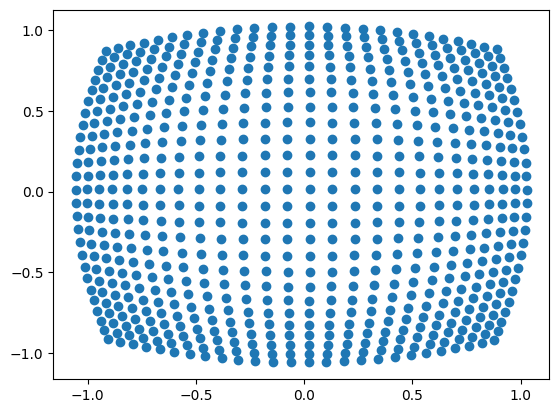

In [5]:
plt.scatter(*out[:, :2].numpy().T)

In [6]:
cam.transform_points(out)

tensor([[  0.0000,   0.0000,   1.0000],
        [  0.0000,  20.0000,   1.0000],
        [  0.0000,  40.0000,   1.0000],
        ...,
        [500.0000, 460.0000,   1.0000],
        [500.0000, 480.0000,   1.0000],
        [499.9999, 499.9999,   1.0000]])

### Initialize Dataset

torch.Size([10, 3, 518, 518]) torch.Size([987, 1]) torch.Size([987, 3]) torch.Size([987, 3]) torch.Size([10, 7])


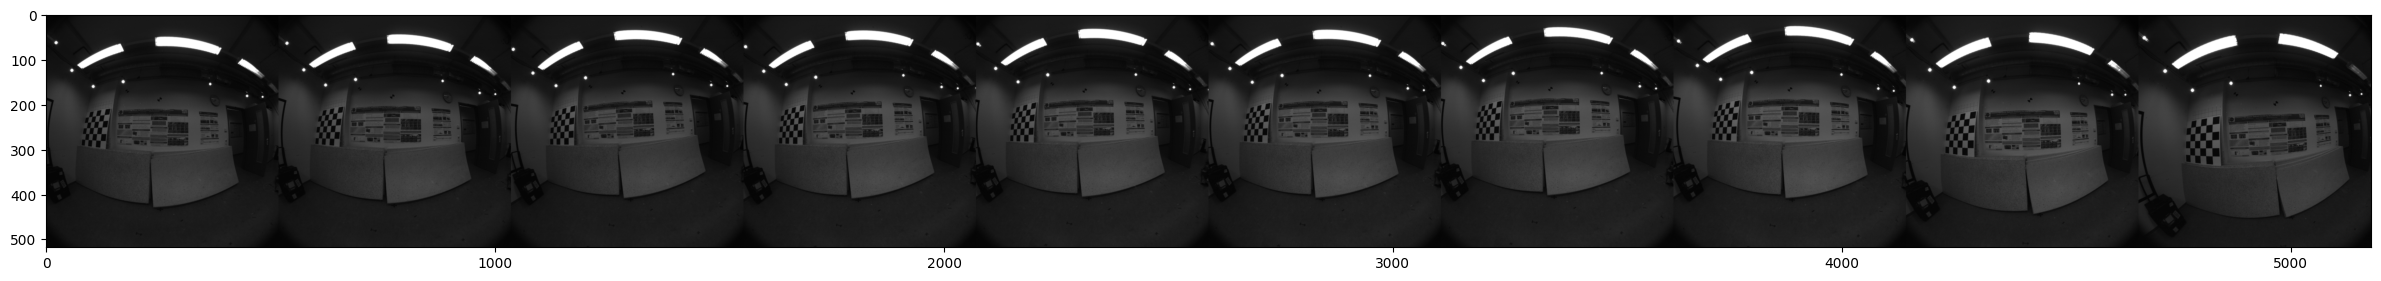

In [7]:
transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),  # this makes the image (and training masks) contiguous and floats
    ]
)

seq_len = 10

dataset = TUMVisualInertialDataset(
    #path="../datasets/dataset-corridor4_512_16/dso",
    path="/home/ilari/Downloads/dataset-corridor4_512_16/dso",
    transforms=transform,
    sequence_length=seq_len,
    skip_frames=10,
)

X = dataset[0]
print(X["cam0"].shape, X["dt"].shape, X["acc"].shape, X["gyro"].shape, X["gt_pose"].shape)

s, h, w, c = X["cam0"].shape

plt.figure(figsize=(30, 10))

plt.imshow(np.concatenate(tuple(X["cam0"].permute(0,2,3,1)), axis=1))

### Initialize Models

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Camera model
fish_cam = FishEyeCameras(
    focal_length=torch.tensor([190.97847715128717]).repeat(2, 1),
    principal_point=torch.tensor([[254.93170605935475, 256.8974428996504]]),
    radial_params=torch.tensor(
        [
            [
                0.373004838186,
                0.372994740336,
                0.498890050897,
                0.502729380663,
                0.00348238940225,
                0.000715034845216,
            ]
        ]
    ),
    # tangential_params=tensor([[0., 0.]]),
    # thin_prism_params=tensor([[0., 0., 0., 0.]]),
    R=torch.tensor([np.eye(3)]),
    T=torch.tensor([[0.0, 0.0, 0.0]]),
    world_coordinates=True,
    use_radial=True,
    use_tangential=False,
    use_thin_prism=False,
    device=device,
    image_size=(512, 512),
)


# Depth Anything
depth_anything = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitb14").to(device).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print("DepthAnything parameters: {:.2f}M".format(total_params / 1e6))

# Extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)


# IMU
integrator = pp.module.IMUPreintegrator(gyro_cov=0.00016, acc_cov=0.0028, reset=True).to(device)

cuda
DepthAnything parameters: 97.47M


In [9]:
def DepthAnythingProcess(batch):
    mean = torch.tensor([0.485, 0.456, 0.406], device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=batch.device).view(1, 3, 1, 1)
    batch = (batch - mean) / std
    batch = batch.contiguous()
    return batch

def extract_keypoints(image, extractor, device):
    #image = load_image(img_path)
    feats = extractor.extract(image.to(device))
    return feats


def match_keypoints(feats0, feats1, matcher):
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1, matches01

def covisibility_graph(num_cams, matches):
    G = nx.Graph()
    for cam_idx in range(num_cams - 1):
        for i, j in matches[cam_idx]:
            G.add_edge((cam_idx, i), (cam_idx + 1, j))

    TC = nx.transitive_closure(G, reflexive=False)
    components = nx.connected_components(TC)
    points3D = [sublist for sublist in components if len(sublist) >= 3]

    cam2pointidx = defaultdict(list)
    for pt_idx, pt in enumerate(points3D):
        for cam, _ in pt:
            cam2pointidx[cam].append(pt_idx)

    return cam2pointidx

def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
    points3D = []
    for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
        U, V = torch.split(keypoints["keypoints"].int(),1, dim=-1)
        keypoint_depths = depths[U, V]
        u_vectors = F.normalize(camera_model.unproject_points(keypoints["keypoints"]))
        points = pose @ (u_vectors * keypoint_depths)
        points3D.append(points)
    return points3D

# def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
#     points3D = []
#     K = torch.tensor(dataset.K, device=device)
#     for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
#         keypoints = keypoints['keypoints'][0] # [N, 2]
#         N = keypoints.shape[0]
#         keypoint_depths = depths[keypoints[:,0].int(), keypoints[:,1].int()]
#         keypoints = torch.cat((keypoints, torch.ones(N, device=keypoints.device).view(-1,1)), dim=-1)
#         undistorted_pixels = F.normalize(camera_model.transform_points(keypoints))[:, :2]
#         points = pp.pixel2point(undistorted_pixels, keypoint_depths, torch.eye(3, device=device))
#         points3D.append(points)
#     return points3D

def batch2device(tensor_dict, device):
    return {k: v.to(device) for k, v in tensor_dict.items()}

In [12]:
# Training loop
for batch_idx, data in enumerate(dataset):
    data = batch2device(data, device)
    image_batch = data["cam0"]
    feature_points = []
    all_matches = []

    # Get initial poses through IMU
    integrator.pos = data['gt_pose'][0].translation()
    integrator.rot = data['gt_pose'][0].rotation()

    state = integrator(dt=data['dt'] / 2.1, #data['dt']*2,
                    gyro=data['gyro'],
                    acc=data['acc'])
    
    imu_freq = data['dt'].shape[0] // image_batch.shape[0]
    imu_poses = pp.SE3(torch.cat((state['pos'], state['rot']), dim=-1))
    imu_poses = imu_poses[0, ::imu_freq][:image_batch.shape[0]]

    # Extract keypoints
    for i in range(image_batch.shape[0]):
        feature_points.append(extract_keypoints(image_batch[i:i+1], extractor, device))

    # Match keypoints
    for i in range(len(feature_points)-1):
        m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[i], feature_points[i+1], matcher)
        all_matches.append(matches01["matches"].cpu().numpy())

    # Update frame graph
    # cam2matches = covisibility_graph(image_batch.shape[0], all_matches)
    # print(cam2matches[0])
    # print(feature_points[0]["keypoints"][cam2matches[0]])
    
    image_batch = DepthAnythingProcess(image_batch)

    with torch.no_grad():
        depths = depth_anything(image_batch)
        depths = depths / 5 # Scale depth if needed
    points3D = project_keypoint_batch(fish_cam, imu_poses, feature_points, depths)

    # if batch_idx > 50:
    break

### Visualize Results

In [14]:
def visualize_batch(poses, gt_poses, points):
    fig = init_figure()
    fig.update_layout(showlegend=True)
    for pose, gt_pose, X in zip(poses, gt_poses, points):
        R = pose.rotation().matrix().cpu().numpy()
        t = pose.translation().cpu().numpy()
        Rgt = gt_pose.rotation().matrix().cpu().numpy()
        tgt = gt_pose.translation().cpu().numpy()
        K = dataset.K
        X = X.cpu().numpy().squeeze()
        plot_camera(fig, Rgt, tgt, K, text="gt", size=1, color="blue")
        plot_camera(fig, R, t, K, text="pred", size=1, color="green")
        # plot_points(fig, X, color='red')
    fig.show()

visualize_batch(imu_poses, data['gt_pose'], points3D)

In [ ]:
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
plt.imshow(depth[8].cpu().numpy())

NameError: name 'depth' is not defined